In [2]:
import os

assert os.environ['CONDA_DEFAULT_ENV']=='wakai'

In [3]:
from pathlib import Path
import pandas as pd


indir = Path('../tfop')
files=list(indir.glob('*measurements.csv'))
files

[PosixPath('../tfop/TOI5671.01L-jd20220630_MuSCAT3_i_measurements.csv'),
 PosixPath('../tfop/TOI5671.01L-jd20220630_MuSCAT3_z_measurements.csv'),
 PosixPath('../tfop/TOI5671.01L-jd20220630_MuSCAT3_g_measurements.csv'),
 PosixPath('../tfop/TOI5671.01L-jd20220630_MuSCAT3_r_measurements.csv')]

In [4]:
data = {}
for f in files:
    s = str(f).split('_')
    band = s[-2]
    data[band] = pd.read_csv(f)

In [5]:
data[band]

,BJD_TDB,Flux,Err,Airmass,DX(pix),DY(pix),FWHM(pix),Peak(ADU)
0,2.459762e+06,0.99488,0.00747,1.0515,-0.01,-0.72,6.33,3826
1,2.459762e+06,1.00041,0.00740,1.0517,0.16,-2.90,6.62,3641
2,2.459762e+06,1.00907,0.00718,1.0518,0.07,-0.77,7.68,3524
3,2.459762e+06,1.01853,0.00679,1.0520,0.37,-1.61,5.90,5136
4,2.459762e+06,1.01052,0.00679,1.0523,0.46,-1.67,6.58,4257
...,...,...,...,...,...,...,...,...
245,2.459762e+06,1.00445,0.00713,1.7039,0.02,1.60,10.41,2549
246,2.459762e+06,1.01328,0.00740,1.7113,-0.15,1.28,11.21,2088
247,2.459762e+06,1.00772,0.00747,1.7189,-1.41,0.96,9.18,2304
248,2.459762e+06,1.01433,0.00765,1.7265,1.28,1.86,10.68,2030


In [6]:
bands = ['g','r','i','z']

In [7]:
times = [data[b]['BJD_TDB'].values for b in bands]
fluxes = [data[b]['Flux'].values for b in bands]
errs = [data[b]['Err'].values for b in bands]

In [23]:
from pytransit import BaseLPF

lpf = BaseLPF(name='toi5671',
              passbands=bands,
              times=times,
              fluxes=fluxes,
              errors=errs,
              pbids=[0, 1, 2, 3],
              wnids=[0, 1, 2, 3],
              exptimes=[110, 50, 30, 50]
             )

In [24]:
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_g           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   8 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   9 |P| q1_i           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  10 |P| q2_i           U(a = 0, b = 1)                          [    0.00 ..     1.00],
  11 |P| q1_z        

In [25]:
# values from paper
period = 3.30632, 0.0001
tc = 2459685.75, 0.001

In [26]:
times[0].min()

2459761.75468

In [27]:
n=round((times[0].min()-tc[0])/period[0])
n

23

In [28]:
from pytransit.param import NormalPrior as NP
from pytransit.param import UniformPrior as UP

# lpf.set_prior('tc', NP(tc[0]+n*period[0], 0.001))
lpf.set_prior('tc', NP(*tc))
lpf.set_prior('p', NP(*period))

In [29]:
lpf.set_prior('k2', UP(0.06, 0.1))

In [30]:
from limbdark import claret
teff, uteff = 3500, 100
logg, ulogg = 4, 0.1
feh, ufeh = 0, 0.1

lds1 = {}
lds2 = {}
for b in bands:
    qs = claret(b+'*', teff, uteff, logg, ulogg, feh, ufeh, transform=True)
    qs = [round(q, 2) for q in qs]
    lds1[b] = qs[:2]
    lds2[b] = qs[2:]
    print(b, qs)

g [0.7, 0.05, 0.38, 0.07]
r [0.61, 0.02, 0.41, 0.08]
i [0.47, 0.05, 0.32, 0.05]
z [0.41, 0.05, 0.28, 0.04]


In [31]:
lds1

{'g': [0.7, 0.05], 'r': [0.61, 0.02], 'i': [0.47, 0.05], 'z': [0.41, 0.05]}

In [32]:
lds2

{'g': [0.38, 0.07], 'r': [0.41, 0.08], 'i': [0.32, 0.05], 'z': [0.28, 0.04]}

In [33]:
for p in lpf.ps:
    if p.name[0]=='q':
        b = p.name[-1]
        if p.name[1]=='1':
            p.prior = NP(*lds1[b])
        elif p.name[1]=='2':
            p.prior = NP(*lds2[b])
        else:
            raise ValueError()

In [34]:
lpf.ps

[  0 |G| tc             N(μ = 2459685.75, σ = 0.001)             [    -inf ..      inf],
   1 |G| p              N(μ = 3.30632, σ = 0.0001)               [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.06, b = 0.1)                     [    0.00 ..      inf],
   5 |P| q1_g           N(μ = 0.7, σ = 0.05)                     [    0.00 ..     1.00],
   6 |P| q2_g           N(μ = 0.38, σ = 0.07)                    [    0.00 ..     1.00],
   7 |P| q1_r           N(μ = 0.61, σ = 0.02)                    [    0.00 ..     1.00],
   8 |P| q2_r           N(μ = 0.41, σ = 0.08)                    [    0.00 ..     1.00],
   9 |P| q1_i           N(μ = 0.47, σ = 0.05)                    [    0.00 ..     1.00],
  10 |P| q2_i           N(μ = 0.32, σ = 0.05)                    [    0.00 ..     1.00],
  11 |P| q1_z        

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

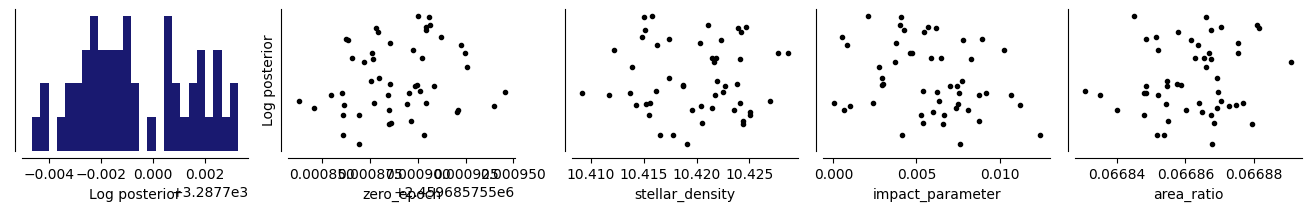

In [35]:
lpf.optimize_global(niter=5000)

In [36]:
from typing import Optional
from numpy import ceil, squeeze, median, percentile
from numpy.random import permutation
from matplotlib.pyplot import subplots, setp
from pytransit.orbits import epoch

def plot_light_curves(self, method='de', ncol: int = 3, width: Optional[float] = None, planet: int = 1,
                          max_samples: int = 1000, figsize=None, data_alpha=0.5, ylim=None):

        solutions = 'best fit de posterior mc mcmc'.split()
        if method not in solutions:
            raise ValueError(f'The "method" needs to be one of {solutions}')

        if width is None:
            if self.nlc == 1:
                width = 24 * self.timea.ptp()
            else:
                width = 2.0

        ncol = min(ncol, self.nlc)
        nrow = int(ceil(self.nlc / ncol))
        tid, pid = self.ps.find_pid("tc"), self.ps.find_pid("p")
        if method in ('mcmc', 'mc', 'posterior'):
            # pvp = self.posterior_samples().to_array().values.copy().T.reshape([-1, len(self.ps)])
            pvp = self.sampler.flatchain
            t0, p = median(pvp[:, tid]), median(pvp[:, pid])
            fmodel = self.flux_model(permutation(pvp)[:max_samples])
            fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)
        elif method in ('de', 'fit', 'best'):
            pv = self.de.minimum_location
            fmodel = squeeze(self.flux_model(pv))
            t0, p = pv[tid], pv[pid]
            fmperc = None
        else:
            raise ValueError

        fig, axs = subplots(nrow, ncol, figsize=figsize, constrained_layout=True, sharey='all', sharex='all',
                            squeeze=False)
        for i in range(self.nlc):
            ax = axs.flat[i]
            e = epoch(self.times[i].mean(), t0, p)
            tc = t0 + e * p
            time = self.times[i] - tc

            ax.plot(time, self.fluxes[i], '.', alpha=data_alpha)

            if method in ('de', 'fit', 'best'):
                ax.plot(time, fmodel[self.lcslices[i]], 'w', lw=4)
                ax.plot(time, fmodel[self.lcslices[i]], 'k', lw=1)
            else:
                ax.fill_between(time, *fmperc[3:5, self.lcslices[i]], alpha=0.15)
                ax.fill_between(time, *fmperc[1:3, self.lcslices[i]], alpha=0.25)
                ax.plot(time, fmperc[0, self.lcslices[i]])

            setp(ax, xlabel=f'Time - T$_c$ [d]', xlim=(-width / 2 / 24, width / 2 / 24))
        setp(axs[:, 0], ylabel='Normalised flux')

        if ylim is not None:
            setp(axs, ylim=ylim)

        for ax in axs.flat[self.nlc:]:
            ax.remove()
        return fig

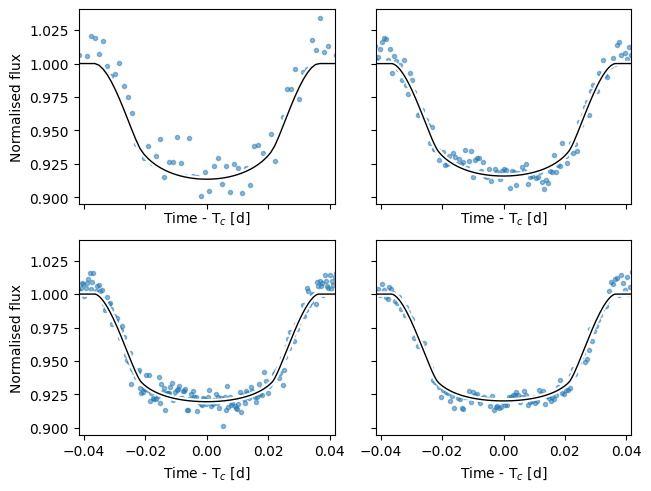

In [37]:
fig = plot_light_curves(lpf, ncol=2, method='de')

In [38]:
lpf.sample_mcmc(niter=5000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

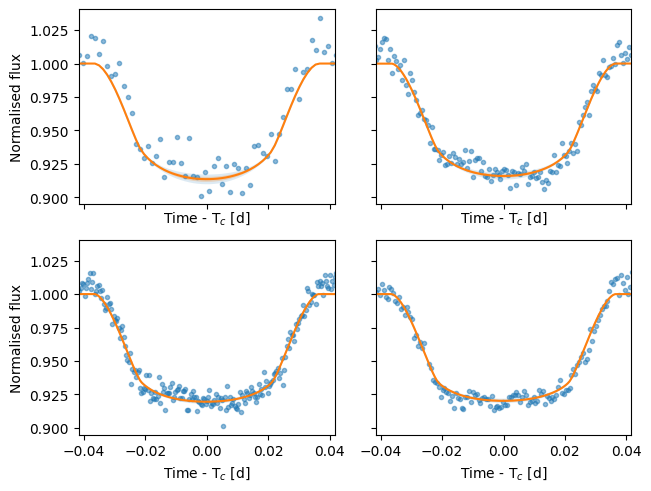

In [39]:
fig = plot_light_curves(lpf, ncol=2, method='mc')

In [ ]:
from corner import coner

fig = corner(df2[cols], labels=cols, show_titles=True, truths=truths, quantiles=[0.16,0.50,0.84]);